# Louvain Performance Benchmarking


In [1]:
# Import needed libraries
import time
import cugraph
import cudf
import numpy as np
from collections import OrderedDict

In [2]:
# NetworkX libraries
import community
import networkx as nx
from scipy.io import mmread

In [3]:
# Test File
data = {
    'preferentialAttachment' : './data/preferentialAttachment.mtx',
    'caidaRouterLevel'       : './data/caidaRouterLevel.mtx',
    'coAuthorsDBLP'          : './data/coAuthorsDBLP.mtx',
    'dblp'                   : './data/dblp-2010.mtx',
    'citationCiteseer'       : './data/citationCiteseer.mtx',
    'coPapersDBLP'           : './data/coPapersDBLP.mtx',
    'coPapersCiteseer'       : './data/coPapersCiteseer.mtx',
    'as-Skitter'             : './data/as-Skitter.mtx'
}

In [4]:
def read_mtx_file(mm_file):
    print('Reading ' + str(mm_file) + '...')
    return mmread(mm_file).asfptype()

In [5]:
def cugraph_call(M, edgevals=False):
    M = M.tocsr()
    if M is None:
        raise TypeError('Could not read the input graph')
    if M.shape[0] != M.shape[1]:
        raise TypeError('Shape is not square')

    # Device data
    row_offsets = cudf.Series(M.indptr)
    col_indices = cudf.Series(M.indices)
    
    if edgevals is False:
        values = None
    else:
        values = cudf.Series(M.data)

    G = cugraph.Graph()
    G.add_adj_list(row_offsets, col_indices, values)

    # cugraph Louvain Call
    print('  cuGraph Solving... ')
    t1 = time.time()
    df = cugraph.nvLouvain(G)
    t2 = time.time() - t1
    return t2



In [6]:
def networkx_call(M):
    M = M.tocsr()
    
    # Directed NetworkX graph
    Gnx = nx.Graph(M)
    # z = {k: 1.0/M.shape[0] for k in range(M.shape[0])}

    # Networkx 
    print('  NetworkX Solving... ')
    t1 = time.time()
    parts = community.best_partition(Gnx)
    t2 = time.time() - t1
    return t2

In [7]:
perf  = []
names = []

for k,v in data.items():
    M = read_mtx_file(v)
    tr = cugraph_call(M)
    tn = networkx_call(M)
    speedUp = (tn / tr)
    names.append(k)
    perf.append(speedUp)
    
    print(str(speedUp) + "x fatser =>  cugraph " + str(tr) + " vs " + str(tn))

Reading ./data/preferentialAttachment.mtx...
  cuGraph Solving... 
  NetworkX Solving... 
10x fatser =>  cugraph 0.263319730758667 vs 10
Reading ./data/caidaRouterLevel.mtx...
  cuGraph Solving... 
  NetworkX Solving... 
10x fatser =>  cugraph 0.0560915470123291 vs 10
Reading ./data/coAuthorsDBLP.mtx...
  cuGraph Solving... 
  NetworkX Solving... 
10x fatser =>  cugraph 0.06368279457092285 vs 10
Reading ./data/dblp-2010.mtx...
  cuGraph Solving... 
  NetworkX Solving... 
10x fatser =>  cugraph 0.07718706130981445 vs 10
Reading ./data/citationCiteseer.mtx...
  cuGraph Solving... 
  NetworkX Solving... 
10x fatser =>  cugraph 0.07314205169677734 vs 10
Reading ./data/coPapersDBLP.mtx...
  cuGraph Solving... 
  NetworkX Solving... 
10x fatser =>  cugraph 0.19674968719482422 vs 10
Reading ./data/coPapersCiteseer.mtx...
  cuGraph Solving... 
  NetworkX Solving... 
10x fatser =>  cugraph 0.17134332656860352 vs 10
Reading ./data/as-Skitter.mtx...
  cuGraph Solving... 
  NetworkX Solving... 
10

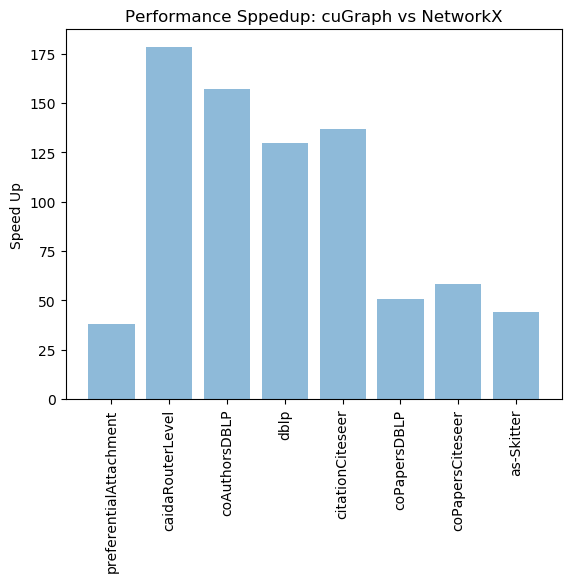

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
y_pos = np.arange(len(names))
 
plt.bar(y_pos, perf, align='center', alpha=0.5)
plt.xticks(y_pos, names)
plt.ylabel('Speed Up')
plt.title('Performance Sppedup: cuGraph vs NetworkX')
plt.xticks(rotation=90) 
plt.show()